# 03 - Exploratory Data Analysis

This notebook performs comprehensive exploratory data analysis (EDA) on the master_races dataset to guide feature engineering and model selection.

**Goals:**
- Understand data distributions and missing patterns
- Analyze target variable (podium) distribution
- Explore relationships between features and target
- Identify temporal trends and patterns
- Generate insights for feature engineering

**Input:** `data/processed/master_races.csv`


In [ ]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set up paths
# Get project root (works whether running from notebooks/ or F1/ folder)
PROJECT_ROOT = Path().resolve()
if PROJECT_ROOT.name == 'notebooks':
    PROJECT_ROOT = PROJECT_ROOT.parent

PROCESSED_ROOT = PROJECT_ROOT / "data" / "processed"

# Load master table
master = pd.read_csv(PROCESSED_ROOT / "master_races.csv")
master['date'] = pd.to_datetime(master['date'], errors='coerce')

print(f"Dataset shape: {master.shape}")
print(f"Memory usage: {master.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"Date range: {master['date'].min()} to {master['date'].max()}")
print(f"Years: {master['year'].min()} - {master['year'].max()}")

# Set plotting style
sns.set_theme(style="darkgrid")
plt.rcParams['figure.figsize'] = (12, 6)


Dataset shape: (12358, 82)
Memory usage: 31.37 MB
Date range: 1994-03-27 00:00:00 to 2024-12-08 00:00:00
Years: 1994 - 2024


## 1. Dataset Overview

Basic statistics, data types, and missing data patterns.


Data Types:
object            38
float64           29
int64             14
datetime64[ns]     1
Name: count, dtype: int64

Columns with missing data (38):
overtake_attempts                100.000000
avg_pit_stops                    100.000000
lap_time_variance                100.000000
throttle_variance                100.000000
sprint_results_resultId           97.086907
sprint_results_constructorId      97.086907
sprint_results_fastestLap         97.086907
sprint_results_milliseconds       97.086907
sprint_results_grid               97.086907
sprint_results_number             97.086907
sprint_results_positionOrder      97.086907
sprint_results_points             97.086907
sprint_results_fastestLapTime     97.086907
sprint_results_statusId           97.086907
sprint_results_positionText       97.086907
sprint_results_position           97.086907
sprint_results_laps               97.086907
sprint_results_time               97.086907
q3                                15.455575
q2       

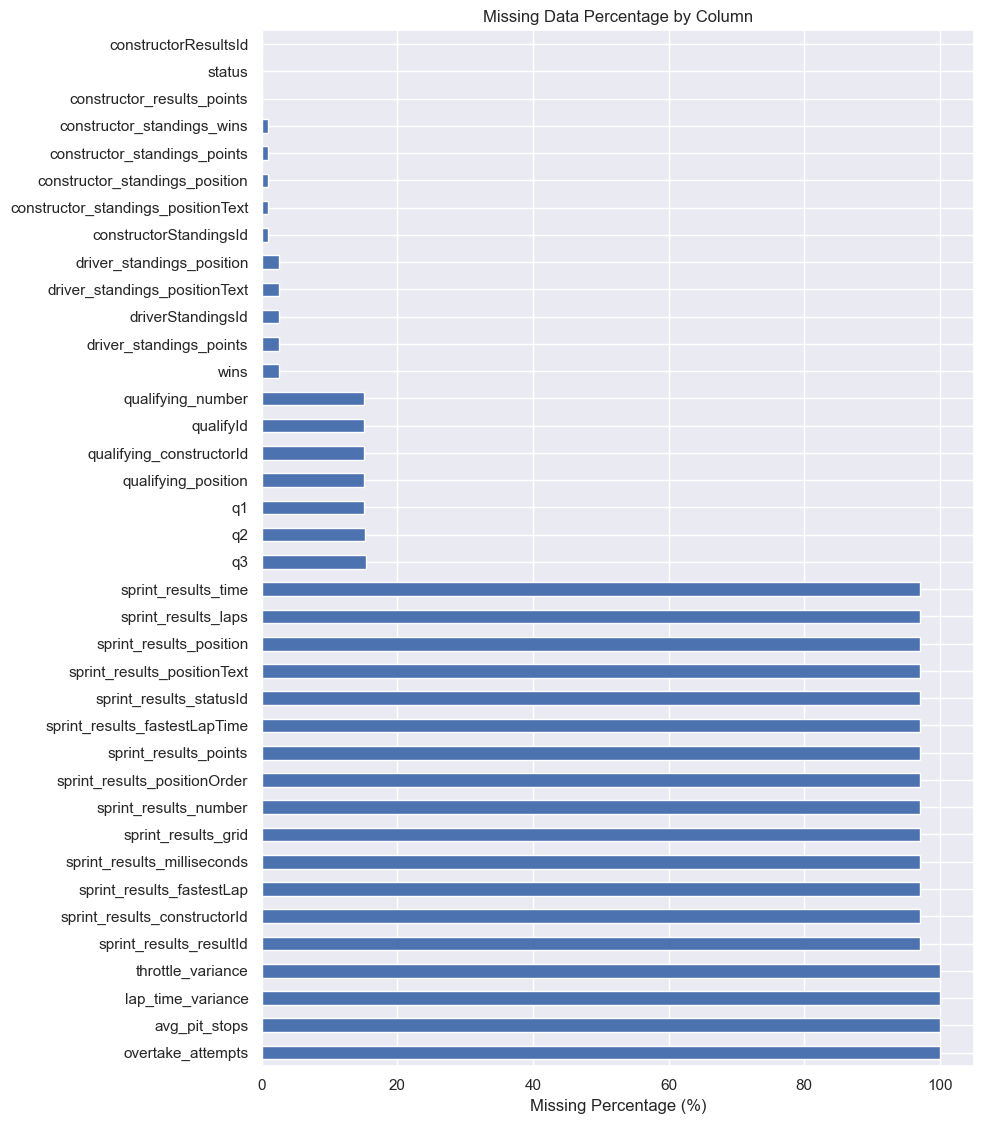

In [11]:
# Data types
print("Data Types:")
print(master.dtypes.value_counts())

# Missing data heatmap
missing_pct = master.isnull().sum() / len(master) * 100
missing_pct = missing_pct[missing_pct > 0].sort_values(ascending=False)

print(f"\nColumns with missing data ({len(missing_pct)}):")
print(missing_pct.head(20).to_string())

# Visualize missing data
if len(missing_pct) > 0:
    plt.figure(figsize=(10, max(6, len(missing_pct) * 0.3)))
    missing_pct.plot(kind='barh')
    plt.title('Missing Data Percentage by Column')
    plt.xlabel('Missing Percentage (%)')
    plt.tight_layout()
    plt.show()


## 2. Target Variable Analysis

Analyze the distribution of the podium target variable.


Target Variable (Podium) Distribution:
podium
0    10627
1     1731
Name: count, dtype: int64

Podium rate: 14.01%
Class imbalance ratio: 6.14:1


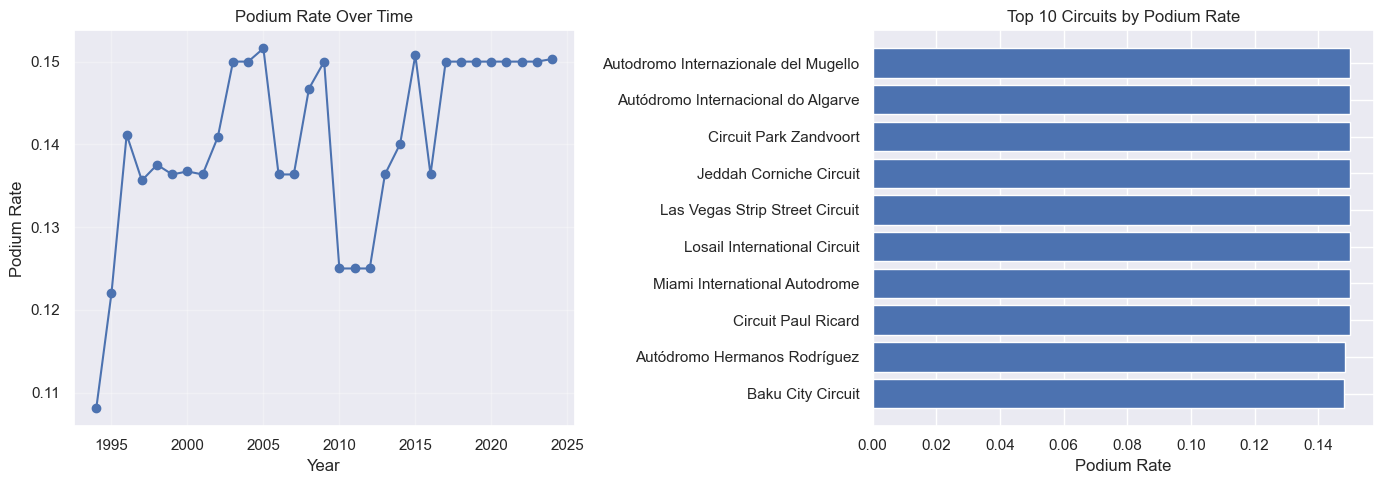

In [12]:
# Target distribution
print("Target Variable (Podium) Distribution:")
print(master['podium'].value_counts())
print(f"\nPodium rate: {master['podium'].mean():.2%}")
print(f"Class imbalance ratio: {(1 - master['podium'].mean()) / master['podium'].mean():.2f}:1")

# Podium distribution by year
podium_by_year = master.groupby('year')['podium'].agg(['sum', 'count', 'mean'])
podium_by_year.columns = ['podiums', 'total', 'podium_rate']

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Podium rate over time
axes[0].plot(podium_by_year.index, podium_by_year['podium_rate'], marker='o')
axes[0].set_title('Podium Rate Over Time')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Podium Rate')
axes[0].grid(True, alpha=0.3)

# Podium distribution by circuit
if 'circuit_name' in master.columns:
    podium_by_circuit = master.groupby('circuit_name')['podium'].mean().sort_values(ascending=False)
    top_circuits = podium_by_circuit.head(10)
    axes[1].barh(range(len(top_circuits)), top_circuits.values)
    axes[1].set_yticks(range(len(top_circuits)))
    axes[1].set_yticklabels(top_circuits.index)
    axes[1].set_title('Top 10 Circuits by Podium Rate')
    axes[1].set_xlabel('Podium Rate')
    axes[1].invert_yaxis()

plt.tight_layout()
plt.show()


### Understanding Class Imbalance

**What is Class Imbalance?**

Class imbalance occurs when the distribution of classes in a classification problem is highly skewed - one class (the majority class) has significantly more examples than another class (the minority class). In our case:
- **Majority class (No Podium)**: ~86% of races (10,627 examples)
- **Minority class (Podium)**: ~14% of races (1,731 examples)
- **Imbalance ratio**: ~6.14:1

**Why is this a problem?**

1. **Model Bias**: Without special handling, machine learning models tend to favor the majority class. A naive model could achieve 86% accuracy by simply predicting "no podium" for every race, but this would be useless for predicting podiums.

2. **Poor Minority Class Performance**: The model may learn to ignore the minority class entirely, resulting in:
   - Low recall for podium predictions (missing many actual podiums)
   - Poor precision if the model does predict podium (many false positives)

3. **Misleading Metrics**: Accuracy becomes a poor metric. A model with 90% accuracy might have 0% recall for podiums.

**How to handle class imbalance:**

1. **Resampling Techniques**:
   - **Oversampling**: Duplicate or generate synthetic examples of the minority class (e.g., SMOTE)
   - **Undersampling**: Remove examples from the majority class (risky - loses data)

2. **Class Weights**: Assign higher weights to minority class examples during training (most models support this)

3. **Threshold Tuning**: Adjust the prediction threshold (default 0.5) to optimize for precision/recall based on use case

4. **Appropriate Metrics**: Use metrics that account for imbalance:
   - **ROC-AUC**: Area under the receiver operating characteristic curve
   - **Precision-Recall AUC**: Better for imbalanced datasets
   - **F1-Score**: Harmonic mean of precision and recall
   - **Log Loss**: Penalizes confident wrong predictions

5. **Ensemble Methods**: Some algorithms (like LightGBM, CatBoost) handle imbalance better than others

**For this project**: We'll use class weights and focus on ROC-AUC and Precision-Recall AUC as our primary metrics, as they're more informative than accuracy for imbalanced problems.


## 3. Feature Distributions

Explore distributions of key features.


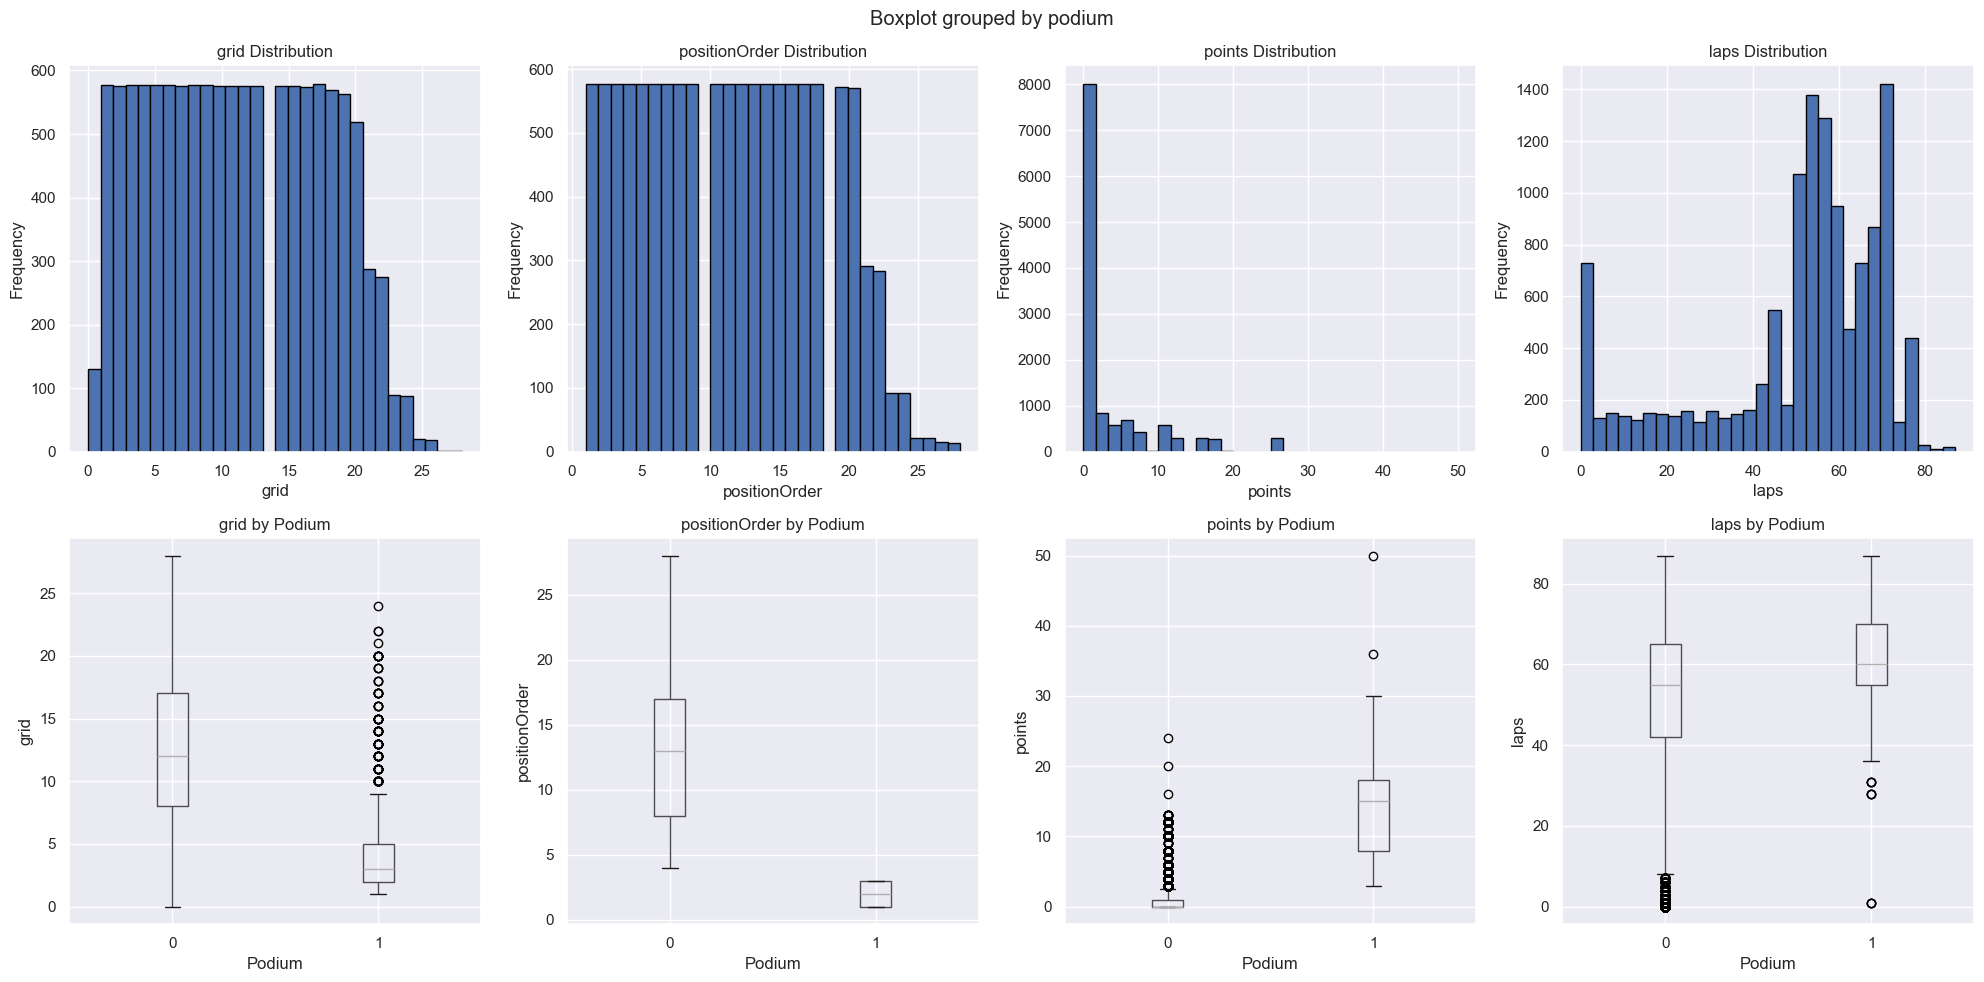

In [13]:
# Key numeric features
numeric_features = ['grid', 'positionOrder', 'points', 'laps', 'driver_age']
available_numeric = [f for f in numeric_features if f in master.columns]

if available_numeric:
    fig, axes = plt.subplots(2, len(available_numeric), figsize=(5*len(available_numeric), 10))
    if len(available_numeric) == 1:
        axes = axes.reshape(-1, 1)
    
    for idx, feature in enumerate(available_numeric):
        # Distribution
        axes[0, idx].hist(master[feature].dropna(), bins=30, edgecolor='black')
        axes[0, idx].set_title(f'{feature} Distribution')
        axes[0, idx].set_xlabel(feature)
        axes[0, idx].set_ylabel('Frequency')
        
        # Box plot by podium
        if 'podium' in master.columns:
            master.boxplot(column=feature, by='podium', ax=axes[1, idx])
            axes[1, idx].set_title(f'{feature} by Podium')
            axes[1, idx].set_xlabel('Podium')
            axes[1, idx].set_ylabel(feature)
    
    plt.tight_layout()
    plt.show()


## 4. Relationships & Correlations

Analyze relationships between features and the target variable.


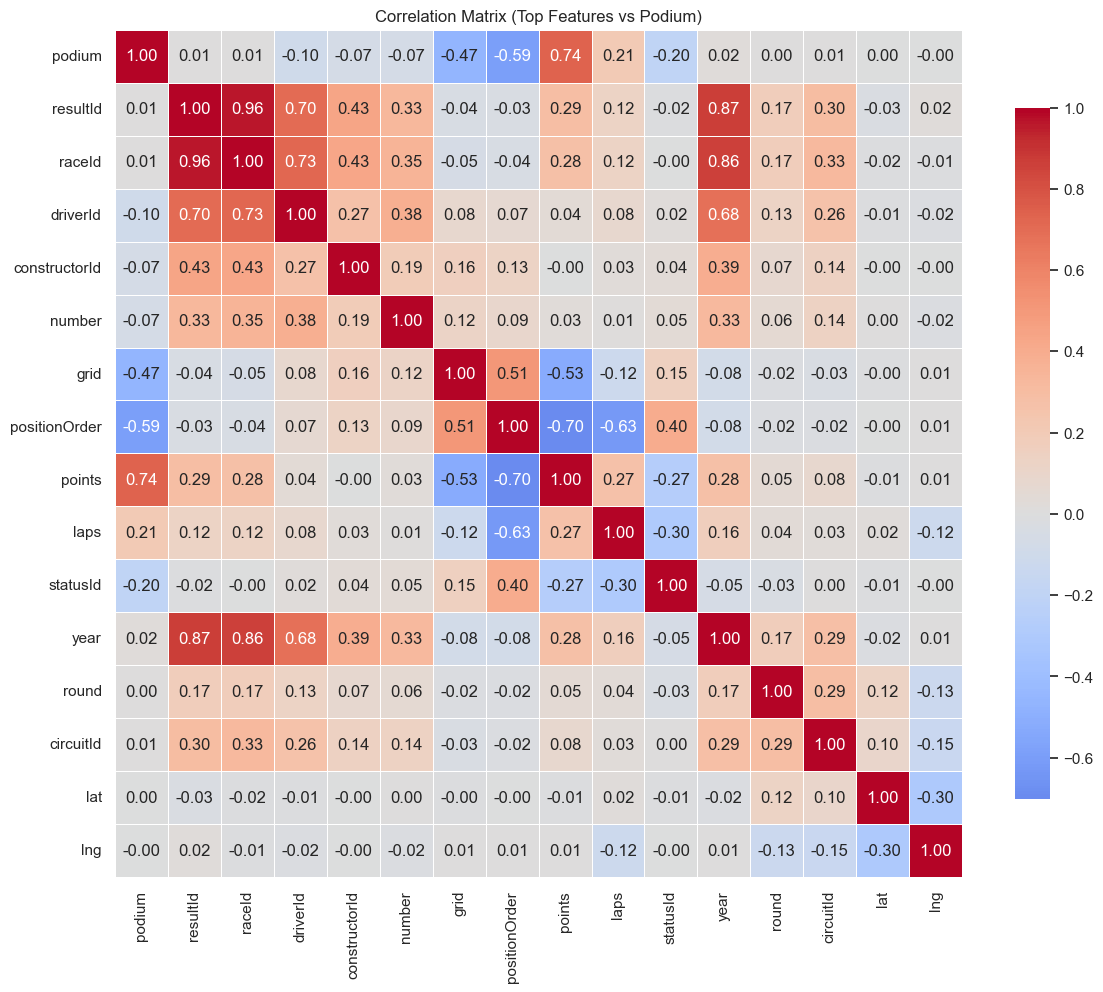

Top correlations with podium:
points           0.739175
positionOrder    0.593113
grid             0.468629
laps             0.207536
statusId         0.199841
driverId         0.101332
number           0.068430
constructorId    0.066598
year             0.017652
raceId           0.008871


In [14]:
# Correlation with target variable (podium)
numeric_cols = master.select_dtypes(include=[np.number]).columns.tolist()
if 'podium' in numeric_cols:
    corr_cols = ['podium'] + [c for c in numeric_cols if c != 'podium' and c in master.columns][:15]
    corr_matrix = master[corr_cols].corr()
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
                square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
    plt.title('Correlation Matrix (Top Features vs Podium)')
    plt.tight_layout()
    plt.show()
    
    # Top correlations with podium
    podium_corr = corr_matrix['podium'].drop('podium').abs().sort_values(ascending=False)
    print("Top correlations with podium:")
    print(podium_corr.head(10).to_string())


## 4.5. Feature Correlation Analysis (Multicollinearity Check)

**Purpose**: Identify highly correlated features to avoid adding redundant information (noise) to the model.

**Why this matters:**
- **Multicollinearity**: When features are highly correlated with each other, they provide redundant information
- **Model Issues**: Can cause:
  - Unstable coefficient estimates
  - Difficulty interpreting feature importance
  - Overfitting
  - Increased model complexity without benefit
- **Feature Selection**: We should keep only one feature from highly correlated pairs, or create composite features

**What to look for:**
- **High correlation (|r| > 0.8)**: Strong multicollinearity - likely redundant features
- **Moderate correlation (0.5 < |r| < 0.8)**: Some redundancy - consider feature engineering
- **Low correlation (|r| < 0.5)**: Features are relatively independent

**Common correlated pairs to check:**
- `grid` vs `qualifying position` (should be highly correlated)
- `positionOrder` vs `points` (points depend on finishing position)
- `points` vs `podium` (podium is a subset of points)
- `driver_standings_points` vs `constructor_standings_points` (related but different)
- `laps` vs `statusId` (completed laps vs race status)
- `year` vs `round` (temporal features)
- Geographic features (`lat`, `lng`, `alt`) - may be correlated


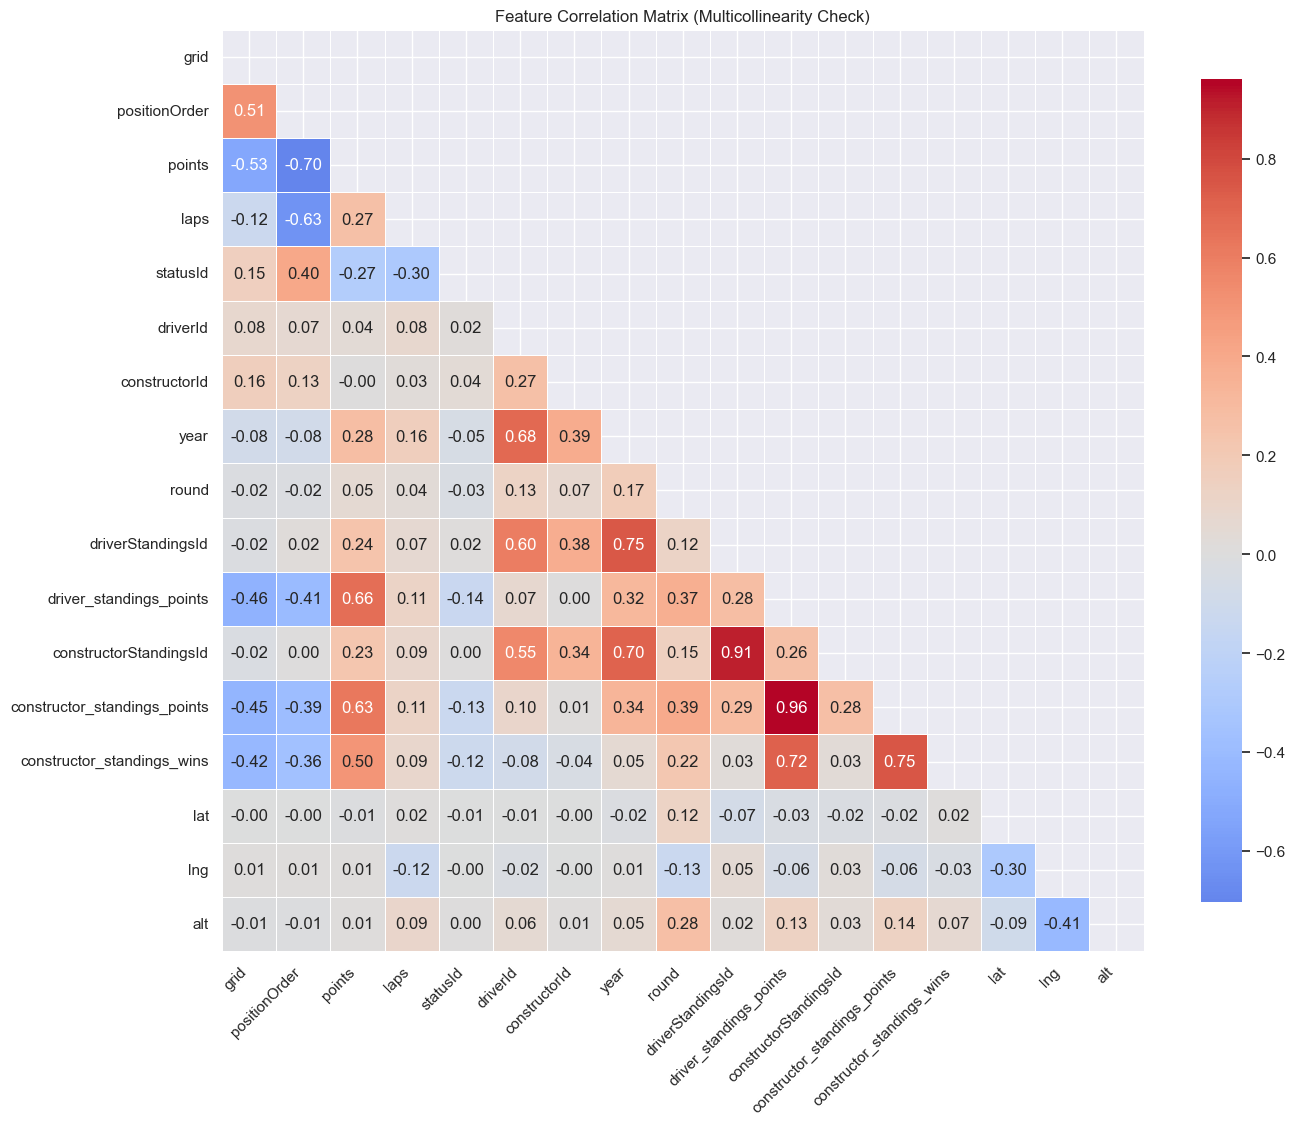


HIGHLY CORRELATED FEATURE PAIRS (|r| > 0.7)
These features may be redundant - consider keeping only one or creating composite features

driver_standings_points        <-> constructor_standings_points   :  0.961
driverStandingsId              <-> constructorStandingsId         :  0.914
constructor_standings_points   <-> constructor_standings_wins     :  0.750
year                           <-> driverStandingsId              :  0.746
driver_standings_points        <-> constructor_standings_wins     :  0.720
positionOrder                  <-> points                         : -0.702
year                           <-> constructorStandingsId         :  0.701

Total highly correlated pairs found: 7

Recommendations:
- Consider removing one feature from each highly correlated pair
- Or create composite features that capture the relationship
- Keep the feature that is more interpretable or has stronger predictive power

Moderately correlated pairs (0.5 < |r| < 0.7): 8
These may still provide s

In [15]:
# Comprehensive correlation analysis between features (not just with podium)
# Select key numeric features that might be correlated
key_features = [
    'grid', 'positionOrder', 'points', 'laps', 'statusId',
    'driverId', 'constructorId', 'year', 'round',
    'driverStandingsId', 'driver_standings_points', 'driver_standings_wins',
    'constructorStandingsId', 'constructor_standings_points', 'constructor_standings_wins',
    'lat', 'lng', 'alt'
]

# Filter to features that exist in the dataset
available_features = [f for f in key_features if f in master.columns]
numeric_available = [f for f in available_features if master[f].dtype in [np.int64, np.float64]]

# Calculate correlation matrix for these features
if len(numeric_available) > 1:
    feature_corr = master[numeric_available].corr()
    
    # Create a mask for the upper triangle (to avoid duplicate pairs)
    mask = np.triu(np.ones_like(feature_corr, dtype=bool))
    
    # Plot correlation heatmap
    plt.figure(figsize=(14, 12))
    sns.heatmap(feature_corr, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', 
                center=0, square=True, linewidths=0.5, cbar_kws={"shrink": 0.8},
                xticklabels=feature_corr.columns, yticklabels=feature_corr.columns)
    plt.title('Feature Correlation Matrix (Multicollinearity Check)')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # Find highly correlated pairs (excluding self-correlations)
    high_corr_pairs = []
    for i in range(len(feature_corr.columns)):
        for j in range(i+1, len(feature_corr.columns)):
            corr_val = feature_corr.iloc[i, j]
            if abs(corr_val) > 0.7:  # Threshold for high correlation
                high_corr_pairs.append({
                    'feature1': feature_corr.columns[i],
                    'feature2': feature_corr.columns[j],
                    'correlation': corr_val
                })
    
    # Sort by absolute correlation
    high_corr_pairs = sorted(high_corr_pairs, key=lambda x: abs(x['correlation']), reverse=True)
    
    print("\n" + "="*70)
    print("HIGHLY CORRELATED FEATURE PAIRS (|r| > 0.7)")
    print("="*70)
    print("These features may be redundant - consider keeping only one or creating composite features\n")
    
    if high_corr_pairs:
        for pair in high_corr_pairs:
            print(f"{pair['feature1']:30s} <-> {pair['feature2']:30s} : {pair['correlation']:6.3f}")
        
        print(f"\nTotal highly correlated pairs found: {len(high_corr_pairs)}")
        print("\nRecommendations:")
        print("- Consider removing one feature from each highly correlated pair")
        print("- Or create composite features that capture the relationship")
        print("- Keep the feature that is more interpretable or has stronger predictive power")
    else:
        print("No highly correlated pairs found (|r| > 0.7)")
        print("This is good - features are relatively independent")
    
    # Check for moderate correlations (0.5 < |r| < 0.7)
    moderate_corr_pairs = []
    for i in range(len(feature_corr.columns)):
        for j in range(i+1, len(feature_corr.columns)):
            corr_val = feature_corr.iloc[i, j]
            if 0.5 < abs(corr_val) <= 0.7:
                moderate_corr_pairs.append({
                    'feature1': feature_corr.columns[i],
                    'feature2': feature_corr.columns[j],
                    'correlation': corr_val
                })
    
    moderate_corr_pairs = sorted(moderate_corr_pairs, key=lambda x: abs(x['correlation']), reverse=True)
    
    if moderate_corr_pairs:
        print(f"\nModerately correlated pairs (0.5 < |r| < 0.7): {len(moderate_corr_pairs)}")
        print("These may still provide some unique information, but monitor during feature selection")
else:
    print("Not enough numeric features available for correlation analysis")


### Understanding Temporal Analysis

**What is Temporal Analysis?**

Temporal analysis examines how patterns, relationships, and distributions change over time. In Formula 1, this is crucial because the sport has evolved significantly over the decades.

**What we're looking for in temporal analysis:**

1. **Era Effects**:
   - **Rule Changes**: F1 has undergone major regulation changes (e.g., 2014 hybrid era, 2022 ground effect era)
   - **Technology Evolution**: Improvements in car design, aerodynamics, and tire technology
   - **Competitive Balance**: Some eras are more competitive (more teams winning) than others
   - **Question**: Do podium probabilities change between eras? Are certain features more predictive in different eras?

2. **Trends Over Time**:
   - **Performance Trends**: Are drivers getting faster? Are gaps between teams narrowing?
   - **Reliability Trends**: Are cars more reliable now (fewer DNFs)?
   - **Strategy Evolution**: How have race strategies changed (pit stops, tire management)?
   - **Question**: Should we use different models or features for different time periods?

3. **Seasonal Patterns**:
   - **Circuit Characteristics**: Do certain types of circuits favor certain drivers/teams?
   - **Weather Patterns**: Are weather conditions changing over time?
   - **Question**: Are there patterns within a season that we can exploit?

4. **Driver/Constructor Evolution**:
   - **Career Trajectories**: How do drivers perform at different stages of their careers?
   - **Team Development**: How do constructors improve or decline over time?
   - **Question**: Should we weight recent performance more heavily than historical performance?

5. **Data Quality Changes**:
   - **Data Availability**: More detailed data available in recent years (telemetry, weather)
   - **Data Completeness**: Are there gaps in historical data that could affect model performance?
   - **Question**: Can we use the same features across all time periods, or do we need era-specific features?

**Why this matters for modeling:**

- **Feature Engineering**: We may need to create era-specific features or normalize features by era
- **Train/Test Split**: We should use temporal splits (train on older data, test on newer) to avoid data leakage
- **Model Selection**: Some models may perform better in certain eras
- **Validation Strategy**: We should validate model performance across different eras to ensure robustness

**Expected Findings:**
- Podium rates may differ between eras (e.g., 1994-2017 vs 2018-2024)
- Grid position importance may have changed (overtaking easier/harder in different eras)
- Driver/constructor dominance patterns may shift over time
- Certain features may be more predictive in specific eras


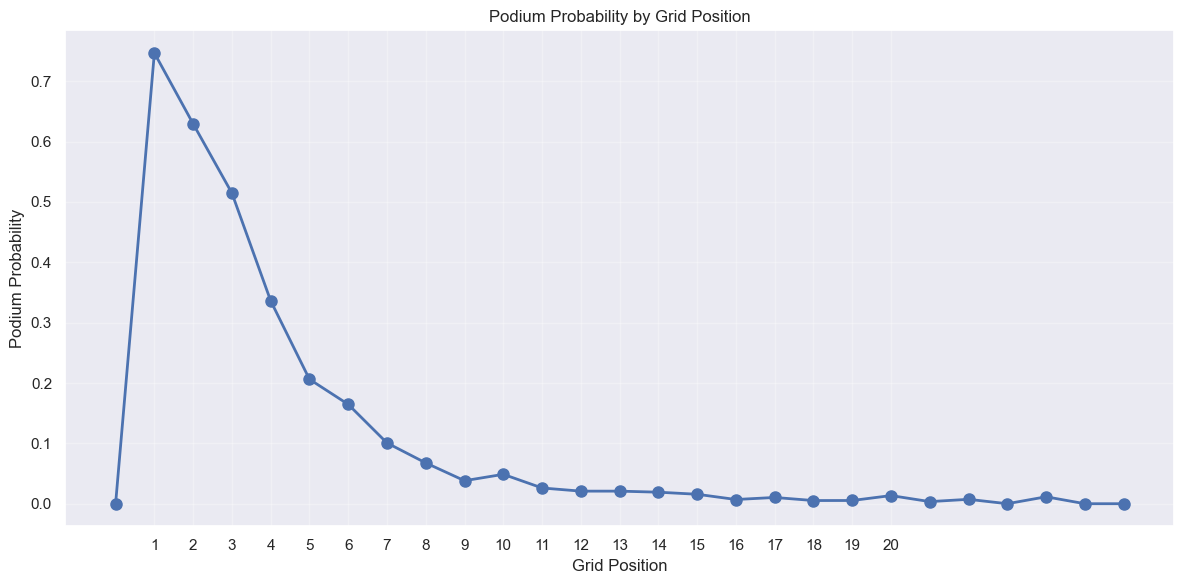

Podium rate from pole (grid=1): 74.70%
Podium rate from top 3: 58.63%
Podium rate from top 10: 27.91%


In [16]:
# Grid position vs podium probability
if 'grid' in master.columns and 'podium' in master.columns:
    grid_podium = master.groupby('grid')['podium'].agg(['mean', 'count'])
    grid_podium = grid_podium[grid_podium['count'] >= 10]  # Only show positions with enough data
    
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(grid_podium.index, grid_podium['mean'], marker='o', linewidth=2, markersize=8)
    ax.set_title('Podium Probability by Grid Position')
    ax.set_xlabel('Grid Position')
    ax.set_ylabel('Podium Probability')
    ax.set_xticks(range(1, min(21, int(grid_podium.index.max()) + 1)))
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"Podium rate from pole (grid=1): {master[master['grid']==1]['podium'].mean():.2%}")
    print(f"Podium rate from top 3: {master[master['grid']<=3]['podium'].mean():.2%}")
    print(f"Podium rate from top 10: {master[master['grid']<=10]['podium'].mean():.2%}")


## 5. Temporal Analysis

Analyze trends over time and performance by era.


Performance by Era:
             podium       grid    points
era                                     
1994-2017  0.136902  11.385649  2.612805
2018-2024  0.150050  10.063780  5.072675


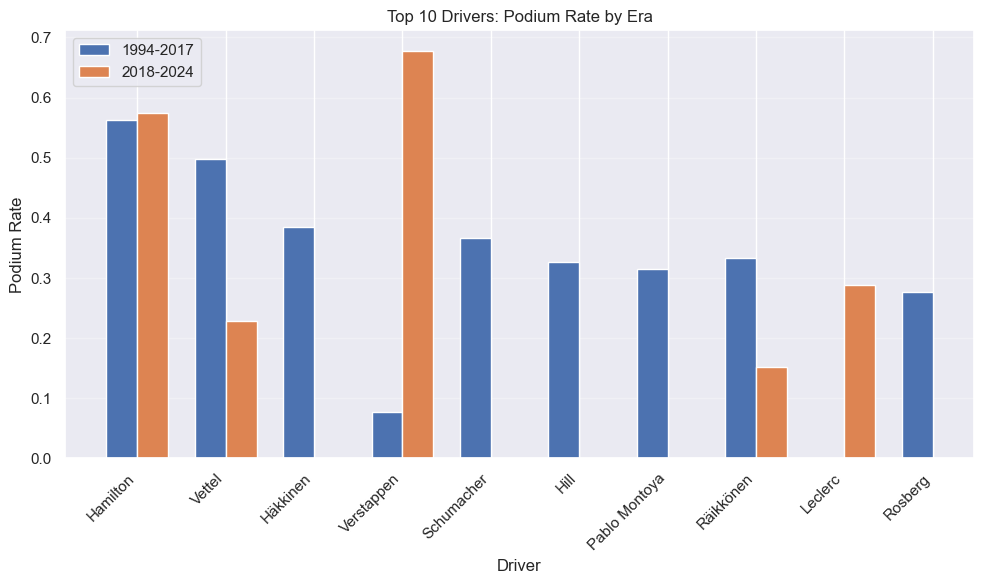

In [17]:
# Performance trends by era
master['era'] = pd.cut(master['year'], 
                       bins=[1993, 2017, 2025], 
                       labels=['1994-2017', '2018-2024'])

if 'era' in master.columns:
    era_stats = master.groupby('era').agg({
        'podium': 'mean',
        'grid': 'mean',
        'points': 'mean'
    })
    
    print("Performance by Era:")
    print(era_stats.to_string())
    
    # Driver performance trends
    if 'driverId' in master.columns and 'surname' in master.columns:
        # Top drivers by podium rate
        driver_podium = master.groupby(['surname', 'era'])['podium'].mean().reset_index()
        top_drivers = master.groupby('surname')['podium'].mean().nlargest(10).index
        driver_podium_top = driver_podium[driver_podium['surname'].isin(top_drivers)]
        
        if len(driver_podium_top) > 0:
            pivot = driver_podium_top.pivot(index='surname', columns='era', values='podium')
            pivot = pivot.reindex(top_drivers)
            
            fig, ax = plt.subplots(figsize=(10, 6))
            x = np.arange(len(pivot))
            width = 0.35
            eras = pivot.columns.tolist()
            for i, era in enumerate(eras):
                ax.bar(x + i*width, pivot[era], width, label=era)
            ax.set_xlabel('Driver')
            ax.set_ylabel('Podium Rate')
            ax.set_title('Top 10 Drivers: Podium Rate by Era')
            ax.set_xticks(x + width/2)
            ax.set_xticklabels(pivot.index, rotation=45, ha='right')
            ax.legend()
            ax.grid(True, alpha=0.3, axis='y')
            plt.tight_layout()
            plt.show()


## 6. EDA Insights Summary

Summarize key findings for feature engineering.


In [18]:
# Generate insights summary
insights = {
    'target_distribution': {
        'podium_rate': float(master['podium'].mean()),
        'class_imbalance': float((1 - master['podium'].mean()) / master['podium'].mean())
    },
    'key_features': {
        'grid_position': 'Strong negative correlation with podium (lower grid = higher podium probability)',
        'qualifying': 'Qualifying performance likely important predictor',
        'driver_history': 'Driver historical performance should be included',
        'constructor_history': 'Constructor/team performance important'
    },
    'missing_data': {
        'sprint_results': 'Sprint results only available for recent years',
        'qualifying': 'Some historical races may lack qualifying data',
        'placeholders': 'FastF1 features (lap_time_variance, throttle_variance, etc.) are placeholders'
    },
    'recommendations': [
        'Create rolling historical features (last N races) for drivers and constructors',
        'Engineer grid position features (top 3, top 10, etc.)',
        'Add circuit-specific performance features',
        'Include driver age and experience features',
        'Create era-based features (pre/post 2018)',
        'Handle missing data appropriately (sprint results, qualifying)'
    ]
}

print("EDA Insights Summary:")
print("=" * 60)
print(f"\nTarget Distribution:")
print(f"  Podium rate: {insights['target_distribution']['podium_rate']:.2%}")
print(f"  Class imbalance: {insights['target_distribution']['class_imbalance']:.2f}:1")

print(f"\nKey Features for Modeling:")
for feature, description in insights['key_features'].items():
    print(f"  - {feature}: {description}")

print(f"\nRecommendations for Feature Engineering:")
for i, rec in enumerate(insights['recommendations'], 1):
    print(f"  {i}. {rec}")

# Save insights
import json
insights_path = PROCESSED_ROOT / "eda_insights.json"
with open(insights_path, 'w') as f:
    json.dump(insights, f, indent=2, default=str)

print(f"\nInsights saved to: {insights_path}")


EDA Insights Summary:

Target Distribution:
  Podium rate: 14.01%
  Class imbalance: 6.14:1

Key Features for Modeling:
  - grid_position: Strong negative correlation with podium (lower grid = higher podium probability)
  - qualifying: Qualifying performance likely important predictor
  - driver_history: Driver historical performance should be included
  - constructor_history: Constructor/team performance important

Recommendations for Feature Engineering:
  1. Create rolling historical features (last N races) for drivers and constructors
  2. Engineer grid position features (top 3, top 10, etc.)
  3. Add circuit-specific performance features
  4. Include driver age and experience features
  5. Create era-based features (pre/post 2018)
  6. Handle missing data appropriately (sprint results, qualifying)

Insights saved to: C:\Users\erikv\Downloads\F1\data\processed\eda_insights.json
